 # Asteroid Data Analysis
 
   ![Laser Ablation](Asteroid_Belt.png)

In [1]:
# Required Libraries
import psycopg2
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
from sqlalchemy import create_engine
from mpl_toolkits.mplot3d import Axes3D

/usr/local/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [2]:
#Connecting to the engine and retriving data
engine = create_engine('postgresql://akshen:da@123@127.0.0.1:5432/asteroids')
rnvdf = pd.read_sql_table('asteroid_data', engine)
apvdf = pd.read_sql_table('asteroids_potential_value', engine)
loeadf = pd.read_sql_table('loea_largest_by_diameter', engine)

In [3]:
rnvdf_copy = rnvdf.copy()
rnvdf.shape

(843784, 8)

In [4]:
rnvdf.columns
rnvdf.drop(rnvdf.columns[1], axis=1, inplace=True)

# Identifying Potential Hazardous Asteroids 
#### An object is classified as a potentially hazardous object (PHO) – that is, posing a possible risk to Earth – if, among other conditions, its Earth MOID is less than 0.05 AU.
> A low MOID does not mean that a collision is inevitable as the planets frequently perturb the orbit of small bodies. It is also necessary that the two bodies reach that point in their orbits at the same time before the smaller body is perturbed into a different orbit with a different MOID value. Two Objects gravitationally locked in orbital resonance may never approach one another.

In [5]:
mean_v = rnvdf['moid'].mean()
rnvdf['moid'].fillna(mean_v, inplace=True)
pha = []
for i, row in rnvdf.iterrows():
     pha.append('Y' if float(row[4]) < 0.05 else 'N')
rnvdf['pha'] = pha
rnvdf['pha'].value_counts()

N    833421
Y     10363
Name: pha, dtype: int64

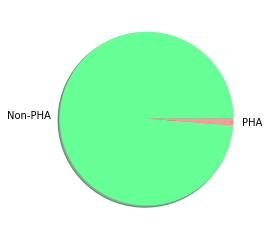

In [28]:
colors = ['#66ff96','#ff9999']
label = ['Non-PHA', 'PHA']
plt.pie(rnvdf['pha'].value_counts(), colors=colors,
       shadow=True, labels=label)

In [7]:
rnvdf['neo_pha'] = (rnvdf.neo == 'Y') & (rnvdf.pha == 'Y')

In [8]:
rnvdf['neo_pha'].value_counts()

False    833447
True      10337
Name: neo_pha, dtype: int64

In [30]:
rnvdf.loc[rnvdf['moid'].idxmin()]

index             649226
full_name    (2011 KE15)
neo                    Y
moid_jup         2.75136
moid         3.43764e-07
producer      Otto Matic
rot_per              NaN
pha                    Y
neo_pha             True
Name: 649226, dtype: object

### Asteroid laser ablation is a proposed method for deflecting asteroids, involving the use of a laser array to alter the orbit of an asteroid. Laser Ablation works by heating up a substance enough to allow gaseous material to eject, either through sublimation (solid to gas) or vaporization (liquid to gas).

![Laser Ablation](ne0710-planetary-defense.jpg)

## Asteroid Mining

In [12]:
loeadf = loeadf.rename(columns={"Name": "full_name"}) 
rnvdf['full_name']= rnvdf.full_name.str.strip()

In [52]:
merge = pd.merge(left=rnvdf, right=loeadf, left_on='full_name', right_on='full_name')
merge.shape
merge.head()

,index_x,full_name,neo,moid_jup,moid,producer,rot_per,pha,neo_pha,index_y,Diameter_in_km_geometric_mean,Dimension_in_km,Mean distance from Sun_in_AU,Date discovered,Discoverer,Class
0,0,1 Ceres,N,2.09753,1.594780,Davide Farnocchia,9.074170,N,False,0,939.4±0.2,964.4 × 964.2 × 891.8,2.766,"January 1, 1801","Piazzi, G.",G
1,1,2 Pallas,N,1.85493,1.233240,Otto Matic,7.813200,N,False,2,512±3,550±4 × 516±3 × 476±3 km[2],2.773,"March 28, 1802","Olbers, H. W.",B
2,2,3 Juno,N,2.18657,1.034540,Otto Matic,7.210000,N,False,10,258,320×267×200,2.672,"September 1, 1804","Harding, K. L.",S
3,3,4 Vesta,N,2.46988,1.139480,Davide Farnocchia,5.342128,N,False,1,525.4±0.2,572.6 × 557.2 × 446.4 ± 0.2,2.362,"March 29, 1807","Olbers, H. W.",V
4,5,6 Hebe,N,2.63580,0.973965,Otto Matic,7.274500,N,False,33,186,205x185x170,2.426,"July 1, 1847","Hencke, K. L.",S


In [73]:
#Biggest Asteroid
biggest_asteroid = [float(x.split('±')[0]) for x in merge.Diameter_in_km_geometric_mean.values]
merge.iloc[biggest_asteroid.index(max(biggest_asteroid))]

index_x                                              0
full_name                                      1 Ceres
neo                                                  N
moid_jup                                       2.09753
moid                                           1.59478
producer                             Davide Farnocchia
rot_per                                        9.07417
pha                                                  N
neo_pha                                          False
index_y                                              0
Diameter_in_km_geometric_mean                939.4±0.2
Dimension_in_km                  964.4 × 964.2 × 891.8
Mean distance from Sun_in_AU                     2.766
Date discovered                        January 1, 1801
Discoverer                                  Piazzi, G.
Class                                                G
Name: 0, dtype: object

In [17]:
freq = dict(merge['Class'].value_counts())
freq = pd.DataFrame(list(freq.items()), columns=['Class', 'Count'])
figure = px.bar(freq, x="Class", y="Count", color=[
    '#1f77b4',  # muted blue
    '#ff7f0e',  # safety orange
    '#2ca02c',  # cooked asparagus green
    '#d62728',  # brick red
    '#9467bd',  # muted purple
    '#8c564b',  # chestnut brown
    '#e377c2',  # raspberry yogurt pink
    '#7f7f7f',  # middle gray
    '#bcbd22',  # curry yellow-green
])
figure.update_layout(showlegend=False)

In [18]:
apvdf = apvdf.rename(columns={"Asteroid": "full_name"})
apvdf.head(11)

,index,full_name,Est_Value,Est_Profit,kmpersec,Composition
0,0,Ryugu,83,30,4.663,"Nickel, iron, cobalt, water, nitrogen, hydroge..."
1,1,1989 ML,14,4,4.889,"Nickel, iron, cobalt"
2,2,Nereus,5,1,4.987,"Nickel, iron, cobalt"
3,3,Bennu,0.7,0.2,5.096,"Iron, hydrogen, ammonia, nitrogen"
4,4,Didymos,62,16,5.162,"Nickel, iron, cobalt"
5,5,2011 UW158,7,2,5.189,"Platinum, nickel, iron, cobalt"
6,6,Anteros,"5,570","1,250",5.440,"Magnesium silicate, aluminum, iron silicate"
7,7,2001 CC21,147,30,5.636,"Magnesium silicate, aluminum, iron silicate"
8,8,1992 TC,84,17,5.648,"Nickel, iron, cobalt"
9,9,2001 SG10,3,0.5,5.880,"Nickel, iron, cobalt"


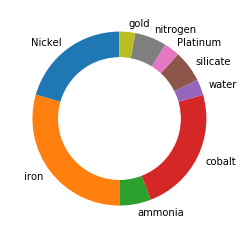

In [27]:
elements = {'Nickel': 0, 'iron': 0 , 'ammonia':0,'cobalt': 0, 'water': 0, 'silicate':0, 'Platinum': 0, 'nitrogen':0,'gold': 0}
for i in elements.keys():
    for j in apvdf.values:
        if i in j[-1]:
            elements[i] +=1

size_of_comp = [float(x) for x in elements.values()]
label = [str(x) for x in elements.keys()]
f =plt.pie(size_of_comp, labels=label, startangle=90)
circle = plt.Circle((0,0), 0.7, color='white')
p=plt.gcf()
p.gca().add_artist(circle)

In [19]:
mining = []
for j in apvdf.values:
    for i in rnvdf.values:
        if j[1] in i[1]:
            mining.append(i)


'162173 Ryugu (1999 JU3)'

In [36]:
for j in mining:
    for i in rnvdf.values:
        if i[1] in j[1]:
            print(i)

[162172 '162173 Ryugu (1999 JU3)' 'Y' 3.70038 0.000638309
 'Davide Farnocchia' 7.627000000000002 'Y']
[10301 '10302 (1989 ML)' 'Y' 3.64912 0.0816366 'Otto Matic' 19.0 'N']
[4659 '4660 Nereus (1982 DB)' 'Y' 3.09769 0.00315334 'Otto Matic' 15.1 'Y']
[101954 '101955 Bennu (1999 RQ36)' 'Y' 3.87795 0.0032228 'Otto Matic'
 4.297 'Y']
[65802 '65803 Didymos (1996 GT)' 'Y' 3.16326 0.0397774 'Davide Farnocchia'
 2.2593 'Y']
[436723 '436724 (2011 UW158)' 'Y' 2.98443 0.00291383 'Otto Matic' 0.61073
 'Y']
[1942 '1943 Anteros (1973 EC)' 'Y' 3.1954700000000003 0.0622122
 'Otto Matic' 2.86923 'N']
[98942 '98943 (2001 CC21)' 'Y' 3.77049 0.0830667 'Otto Matic' 5.017 'N']
[7473 '7474 (1992 TC)' 'Y' 3.44745 0.167212 'Otto Matic' 5.54 'N']
[88785 '88786 (2001 SG107)' 'N' 2.54354 0.808813 'Otto Matic' nan 'N']
[110061 '110062 (2001 SG108)' 'N' 2.4746200000000003 1.28768 'Otto Matic'
 11.393 'N']
[140063 '140064 (2001 SG105)' 'N' 2.23084 1.60907 'Otto Matic' nan 'N']
[194005 '194006 (2001 SG10)' 'Y' 3.12641 

'Ryugu'